# 可转债分钟因子

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import dcube as dc
import matplotlib.pyplot as plt
pro = dc.pro_api('bffee2be40ae0f76164999bd14b0dd02a4f47c3175de036c9c21c864')
from itertools import combinations
%run 可转债因子回测.ipynb


### 东方研报23/07/01 分钟线因子

In [20]:
import os
os.chdir('E:\\FZquan\\ccb_mbars')
def read_mbars(date):
    date = pd.to_datetime(date).date()
    path = 'E:\\FZquan\\ccb_mbars'
    file_name = '{}\\{}.pkl'.format(path,date.strftime('%Y%m%d'))
    if_file_exist = os.path.exists(file_name)
    if if_file_exist:
        mbars = pd.read_pickle(file_name).astype(float)
        return mbars
    else:
        return pd.Penal()


In [22]:
def day_indicator(pkl):
    
    # 日内RSI
    df_5ret = pkl['closeprice'].iloc[1:].resample('5T',label='right',closed='right').last().pct_change()
    sum_pos_ret = df_5ret[df_5ret > 0].sum()
    sum_abs_ret = df_5ret.abs().sum()
    day_rsi = sum_pos_ret / sum_abs_ret
        
    # 温和收益
    df_log_5ret = np.log(df_5ret + 1)
    med = df_log_5ret.median()
    mad = (df_log_5ret - med).abs().median()
    moderate_high = med + 1.96*mad
    moderate_low = med - 1.96*mad
    day_moderate_ret = df_log_5ret[(df_log_5ret <= moderate_high) & (df_log_5ret >= moderate_low)].sum()
    
    # 收益率方差
    day_ret_var = df_5ret.var()
    
    # 收益率偏度
    day_ret_skew = df_5ret.skew()
    
    # 成交量
    day_vol = pkl['volume'].sum()
    
    # 成交量变化率的方差
    df_5vol = pkl['volume'].iloc[1:].resample('5T',label='right',closed='right').sum()
    df_5vol_chg = df_5vol.pct_change()
    day_vol_var = df_5vol_chg.var()
    
    # 成交量变化率的偏度
    day_vol_skew = df_5vol_chg.skew()
    
    # 收盘价和成交量的相关系数
    day_corr = pkl['closeprice'].iloc[1:,].resample('5T',label='right',closed='right').last().corrwith(df_5vol)
    
    # 开盘、尾盘成交量占比
    day_open_vol_pct = pkl['volume'].iloc[0:31,].sum() / pkl['volume'].sum()
    day_close_vol_pct = pkl['volume'].iloc[210:,].sum() / pkl['volume'].sum()

    return day_rsi, day_moderate_ret, day_ret_var, day_ret_skew, day_vol, day_vol_var, day_vol_skew, day_corr,\
            day_open_vol_pct, day_close_vol_pct


In [51]:
# 整理转债列表
date_list = [i[0:8] for i in os.listdir()]
ccb_list = []
for date in tqdm(date_list):
    pkl = read_mbars(date)
    ccb_list+=list(pkl.minor_axis)
ccb_list = list(set(ccb_list))


100%|██████████████████████████████████████████████████████████████████████████████| 1381/1381 [01:49<00:00, 12.56it/s]


In [60]:
# 合并每日因子
df_rsi = pd.DataFrame(index=date_list, columns=ccb_list)
df_moderate_ret = df_rsi.copy()
df_ret_var = df_rsi.copy()
df_ret_skew = df_rsi.copy()
df_vol = df_rsi.copy()
df_vol_var = df_rsi.copy()
df_vol_skew = df_rsi.copy()
df_corr = df_rsi.copy()
df_open_vol_pct = df_rsi.copy()
df_close_vol_pct = df_rsi.copy()

for date in tqdm(date_list):
    pkl = read_mbars(date)
    day_rsi, day_moderate_ret, day_ret_var, day_ret_skew, day_vol, day_vol_var, day_vol_skew, day_corr,\
      day_open_vol_pct, day_close_vol_pct= day_indicator(pkl)
    df_rsi.loc[date,] = day_rsi
    df_moderate_ret.loc[date,] = day_moderate_ret
    df_ret_var.loc[date,] = day_ret_var
    df_ret_skew.loc[date,] = day_ret_skew
    df_vol.loc[date,] = day_vol
    df_vol_var.loc[date,] = day_vol_var
    df_vol_skew.loc[date,] = day_vol_skew
    df_corr.loc[date,] = day_corr
    df_open_vol_pct.loc[date,] = day_open_vol_pct
    df_close_vol_pct.loc[date,] = day_close_vol_pct

for df in [df_rsi, df_moderate_ret, df_ret_var, df_ret_skew, df_vol, df_vol_var, df_vol_skew, df_corr, \
           df_open_vol_pct, df_close_vol_pct]:
    df.index = [datetime.datetime.strptime(str(i), '%Y%m%d').date() for i in df.index]


100%|██████████████████████████████████████████████████████████████████████████████| 1381/1381 [27:42<00:00,  1.20s/it]


In [65]:
# 每日换手率
df_out_bal = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__outstanding_balance.csv',index_col=0)    # 单位万元
df_out_bal.index = pd.to_datetime(df_out_bal.index).date
df_out_bal = df_out_bal.loc[df_vol.index, df_vol.columns]
df_out_bal = df_out_bal.replace(0,np.nan)
df_turn = df_vol / df_out_bal *10
df_turn.to_csv(r'C:\Users\nibh\Desktop\FZ\CCB\turn_over.csv')

In [66]:
#  近5日、10日日内5分钟线RSI
factor_RSI_5 = (df_rsi / df_turn.replace(0,np.nan)).rolling(5).mean()
factor_RSI_10 = (df_rsi / df_turn.replace(0,np.nan)).rolling(10,min_periods=5).mean()

#  近10日、20日温和收益均值
factor_moderate_10 = df_moderate_ret.rolling(10,min_periods=5).mean()
factor_moderate_20 = df_moderate_ret.rolling(20,min_periods=10).mean()

# 近10日、20日日内分钟线收益率方差
factor_retvar_10 = df_ret_var.rolling(10,min_periods=5).mean()
factor_retvar_20 = df_ret_var.rolling(20,min_periods=10).mean()

# 近10日、20日日内分钟线收益率偏度（无图）
factor_retskew_10 = df_ret_skew.rolling(10,min_periods=5).mean()
factor_retskew_20 = df_ret_skew.rolling(20,min_periods=10).mean()

# 近10日、20日日内5分钟线量价相关系数波动率
factor_corrstd_10 = df_corr.rolling(10,min_periods=5).std()
factor_corrstd_20 = df_corr.rolling(20,min_periods=10).std()

# 近60日、120日日内分钟线成交量变化偏度
factor_volskew_60 = df_vol_skew.rolling(60,min_periods=30).mean()
factor_volskew_120 = df_vol_skew.rolling(120,min_periods=60).mean()

#近20日、60日开盘成交占比
factor_open_20 = df_open_vol_pct.rolling(20,min_periods=10).mean()
factor_open_60 = df_open_vol_pct.rolling(60,min_periods=30).mean()

In [204]:
# 排除股债性法一：平底溢价率中性化
import statsmodels.api as sm
df_con_value = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__conv_value.csv',index_col=0)
df_strb_value = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__strbvalue.csv',index_col=0)

df_par_value = df_con_value/df_strb_value - 1
df_par_value.index = pd.to_datetime(df_par_value.index).date
df_par_value = df_par_value.loc[df_vol.index, df_vol.columns]

def par_neutralize(df_factor, df_par_value):
    ls_resid = []
    for date in df_factor.index:
        factor_value = df_factor.loc[date]
        par_value = df_par_value.loc[date]

        # 删除包含 NaN 的行
        combined = pd.concat([factor_value, par_value],axis=1).dropna()
        if not combined.empty:
            factor_value = combined.iloc[:,0]
            par_value = combined.iloc[:,1]
            X = sm.add_constant(par_value)  # 加截距项
            model = sm.OLS(factor_value, X)  # 自动跳过空缺值
            results = model.fit()
            ls_resid.append(results.resid)
        else:
            ls_resid.append(pd.Series(index=df_factor.columns))

    df_residual = pd.concat(ls_resid, axis=1)
    df_residual.columns = df_factor.index
    return df_residual.T


In [224]:
# 排除股债性法二：分域后zscore
df_par_value = df_con_value/df_strb_value - 1
df_par_value.index = pd.to_datetime(df_par_value.index).date
df_par_value = df_par_value.loc[df_vol.index, df_vol.columns]

df_ccb_class = df_par_value.copy()
for code in df_par_value.columns:   # 1偏股，2平衡，3偏债
    df_ccb_class[code] = np.where(df_ccb_class[code]>0.2, 1,
                                  np.where(df_ccb_class[code]>=-0.2, 2,
                                          np.where(df_ccb_class[code]<-0.2, 3, df_ccb_class[code])))

def zscore(series):
    return (series - series.mean()) / series.std()
    
def neutralize(df_factor, df_ccb_class):
    zscored_factor = pd.DataFrame(index=df_factor.index, columns=df_factor.columns)
    for date in tqdm(df_factor.index):
        class_today = df_ccb_class.loc[date]
        ls_stocks_1 = class_today[class_today == 1].index
        ls_stocks_2 = class_today[class_today == 2].index
        ls_stocks_3 = class_today[class_today == 3].index
        
        factors_1 = zscore(df_factor.loc[date, ls_stocks_1])
        factors_2 = zscore(df_factor.loc[date, ls_stocks_2])
        factors_3 = zscore(df_factor.loc[date, ls_stocks_3])

        zscored_factor.loc[date, ls_stocks_1] = factors_1
        zscored_factor.loc[date, ls_stocks_2] = factors_2
        zscored_factor.loc[date, ls_stocks_3] = factors_3
    return zscored_factor

factor_RSI_5 = neutralize(factor_RSI_5,df_ccb_class)
factor_moderate_10 = neutralize(factor_moderate_10,df_ccb_class)
factor_retvar_20 = neutralize(factor_retvar_20,df_ccb_class)
factor_retskew_10 = neutralize(factor_retskew_10,df_ccb_class)
factor_corrstd_10 = neutralize(factor_corrstd_10,df_ccb_class)
factor_open_60 = neutralize(factor_open_60,df_ccb_class)

100%|██████████████████████████████████████████████████████████████████████████████| 1381/1381 [02:02<00:00, 11.29it/s]


In [225]:
factor_RSI_5.to_csv(r'C:\Users\nibh\Desktop\FZ\CCB\factor_RSI_5.csv')
factor_moderate_10.to_csv(r'C:\Users\nibh\Desktop\FZ\CCB\factor_moderate_10.csv')
factor_retvar_20.to_csv(r'C:\Users\nibh\Desktop\FZ\CCB\factor_retvar_20.csv')
factor_retskew_10.to_csv(r'C:\Users\nibh\Desktop\FZ\CCB\factor_retskew_10.csv')
factor_corrstd_10.to_csv(r'C:\Users\nibh\Desktop\FZ\CCB\factor_corrstd_10.csv')
factor_open_60.to_csv(r'C:\Users\nibh\Desktop\FZ\CCB\factor_open_60.csv')

# 平底溢价率回归中性化

factor_name: factor_RSI_5
start_date,end_date 2019-01-01 2023-08-14
2019-01-02
2020-01-10
2021-01-21
2022-02-08
2023-02-17


,turnover,gross,net
group_01,0.076410,0.000648,0.000541
group_02,0.176934,0.000411,0.000164
group_03,0.247208,0.000072,-0.000274
group_04,0.290446,0.000190,-0.000217
group_05,0.336707,-0.000073,-0.000545
group_06,0.319687,-0.000204,-0.000652
group_07,0.255576,-0.000257,-0.000614
group_08,0.232678,-0.000072,-0.000398
group_09,0.218184,-0.000210,-0.000515
group_10,0.107503,-0.000505,-0.000655


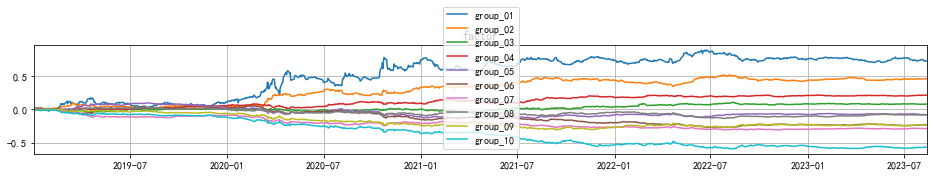

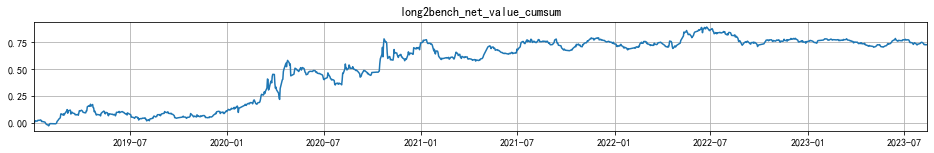

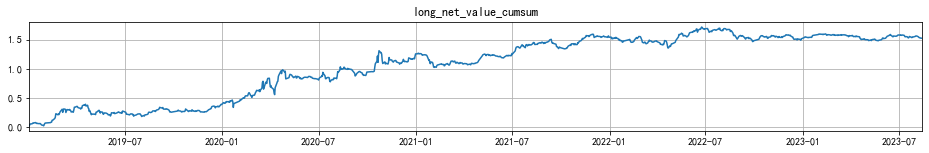

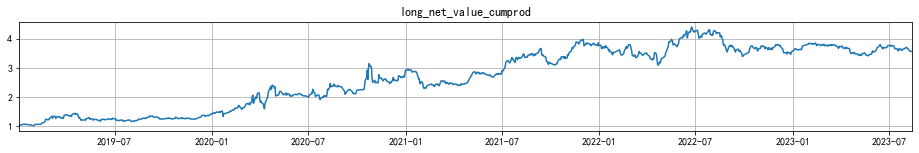

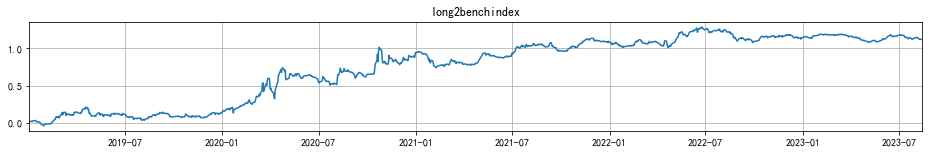

In [139]:
C = SingleFactorAnalysis_CCB(index_pool='ZZZZ',start_date='20190101',end_date='20230814',factor_name='factor_RSI_5',nextpct='pct_close_next_close',long_low=1,dt_index='240m',n_group=10,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_moderate_10
start_date,end_date 2019-01-01 2023-08-14
2019-01-02
2020-01-10
2021-01-21
2022-02-08
2023-02-17


,turnover,gross,net
group_01,0.203715,0.000738,0.000453
group_02,0.436697,0.000039,-0.000572
group_03,0.518034,0.000175,-0.000551
group_04,0.549133,-0.000070,-0.000839
group_05,0.539279,-0.000164,-0.000919
group_06,0.538269,-0.000075,-0.000829
group_07,0.539270,-0.000216,-0.000971
group_08,0.537871,-0.000262,-0.001016
group_09,0.473066,-0.000138,-0.000801
group_10,0.250449,-0.000026,-0.000377


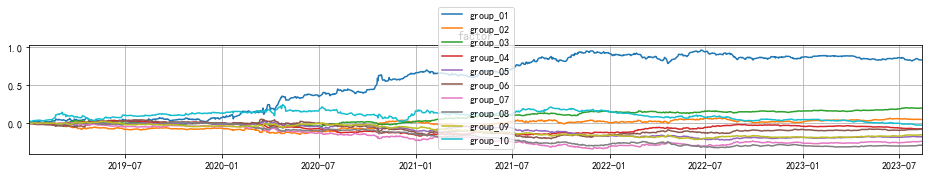

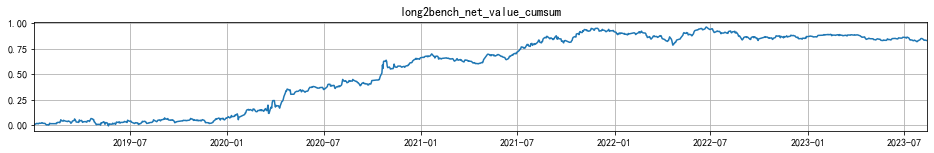

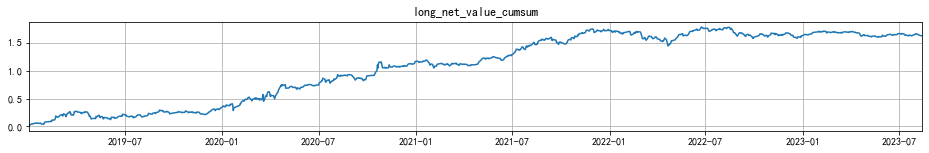

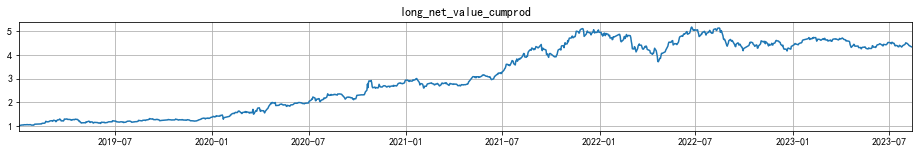

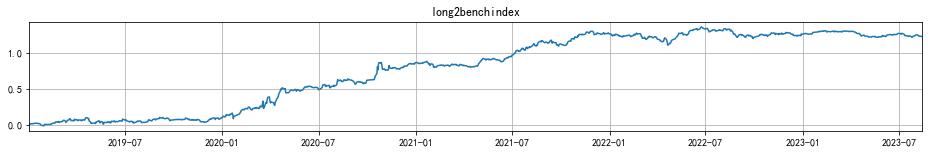

In [141]:
C = SingleFactorAnalysis_CCB(index_pool='ZZZZ',start_date='20190101',end_date='20230814',factor_name='factor_moderate_10',nextpct='pct_close_next_close',long_low=1,dt_index='240m',n_group=10,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_retvar_20
start_date,end_date 2018-01-01 2023-09-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.050990,-0.000136,-0.000207
group_02,0.117218,-0.000083,-0.000247
group_03,0.152944,-0.000064,-0.000278
group_04,0.171865,0.000028,-0.000213
group_05,0.194245,-0.000065,-0.000337
group_06,0.200281,0.000021,-0.000259
group_07,0.177155,0.000140,-0.000108
group_08,0.162447,0.000030,-0.000198
group_09,0.136623,-0.000001,-0.000192
group_10,0.063609,0.000130,0.000041


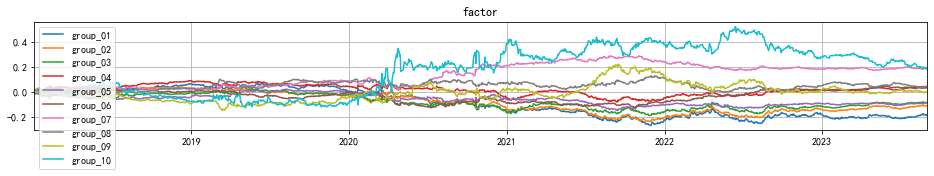

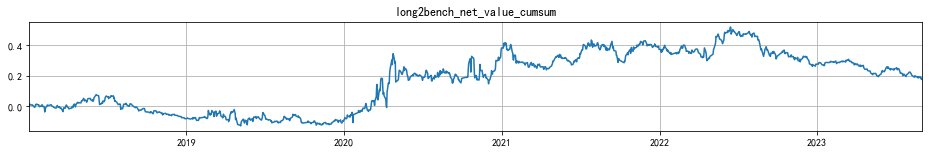

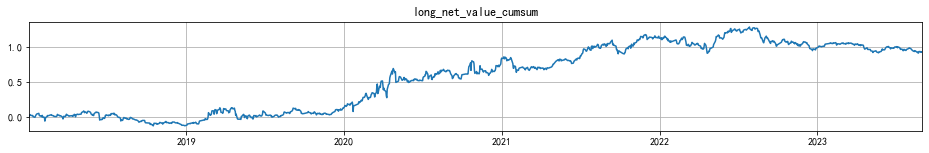

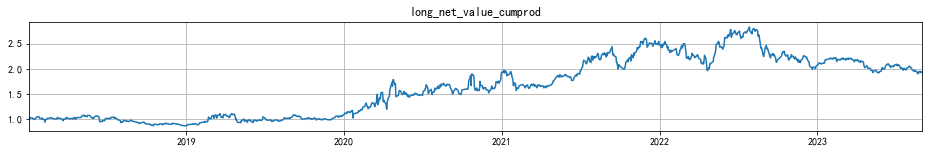

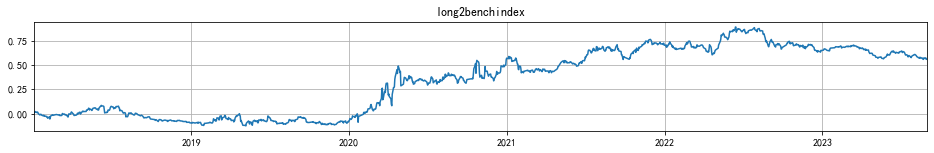

In [148]:
C = SingleFactorAnalysis_CCB(index_pool='ZZZZ',start_date='20180101',end_date='20230901',factor_name='factor_retvar_20',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=10,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: try
start_date,end_date 2019-01-01 2023-08-14
2019-01-02
2020-01-10
2021-01-21
2022-02-08
2023-02-17


,turnover,gross,net
group_01,0.163644,0.000111,-0.000119
group_02,0.310451,0.000040,-0.000395
group_03,0.162892,-0.000151,-0.000379


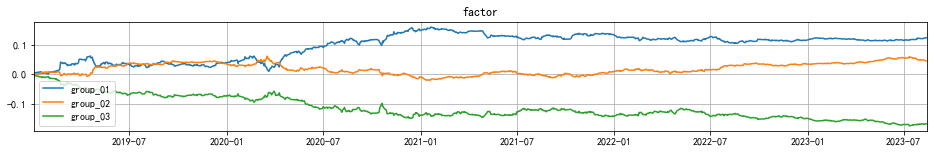

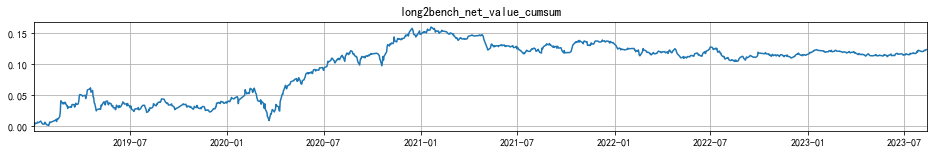

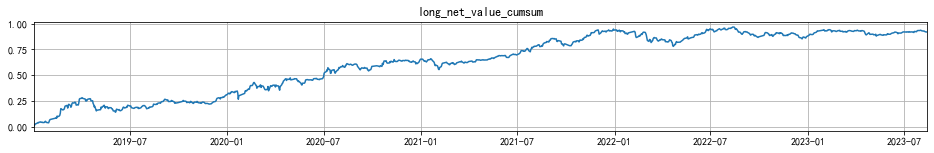

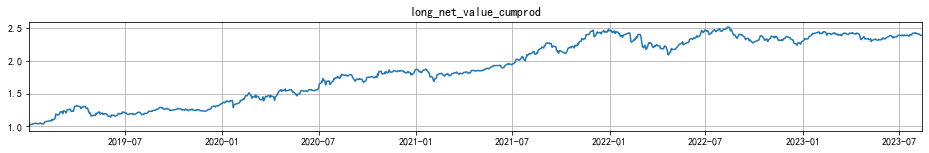

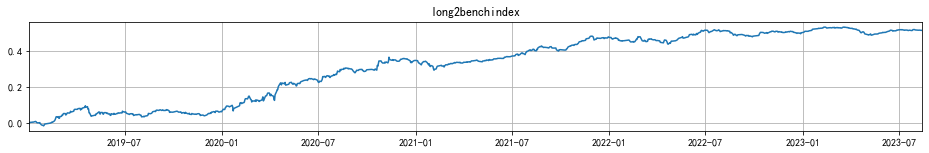

In [159]:
# 平底溢价率中性化后的factor_retskew_10
C = SingleFactorAnalysis_CCB(index_pool='ZZZZ',start_date='20190101',end_date='20230814',factor_name='factor_retskew_10_par',nextpct='pct_close_next_close',long_low=1,dt_index='240m',n_group=3,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_corrstd_10
start_date,end_date 2018-01-01 2023-09-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.170738,-0.000221,-0.000460
group_02,0.297810,0.000076,-0.000341
group_03,0.160774,0.000145,-0.000080


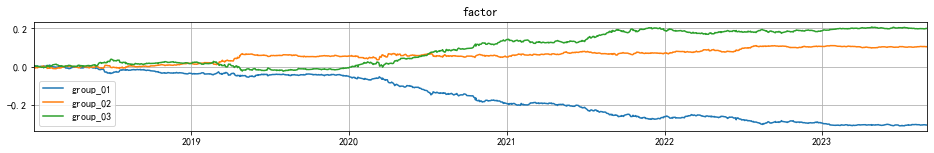

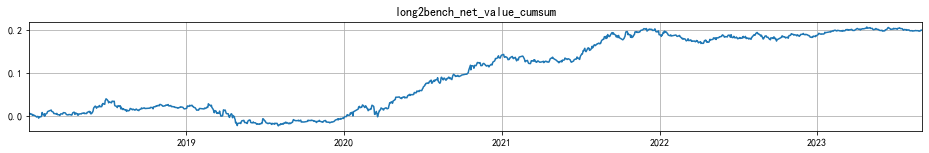

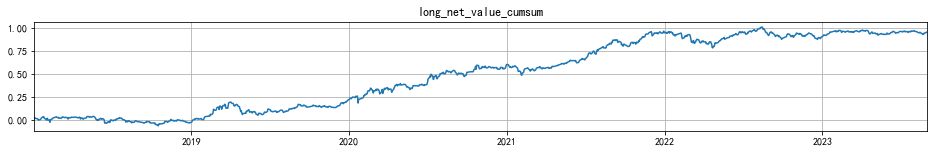

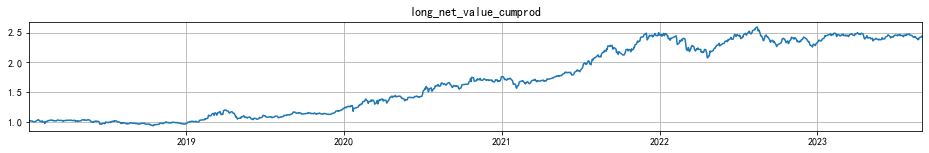

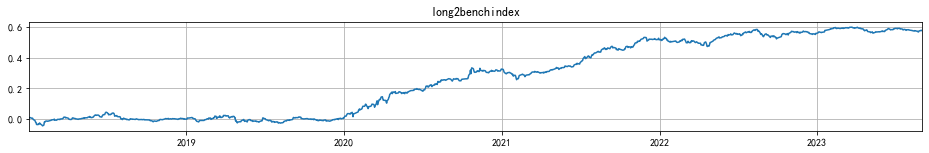

In [177]:
C = SingleFactorAnalysis_CCB(index_pool='ZZZZ',start_date='20180101',end_date='20230901',factor_name='factor_corrstd_10',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=3,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_open_60
start_date,end_date 2018-01-01 2023-09-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.044562,-0.000307,-0.000369
group_02,0.108515,-0.000223,-0.000375
group_03,0.135900,-0.000139,-0.000329
group_04,0.149091,-0.000160,-0.000369
group_05,0.216251,0.000046,-0.000256
group_06,0.223224,-0.000098,-0.000410
group_07,0.167339,-0.000123,-0.000358
group_08,0.156408,0.000135,-0.000084
group_09,0.131926,0.000226,0.000041
group_10,0.059720,0.000643,0.000559


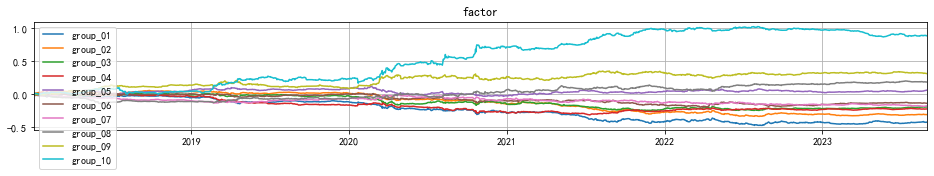

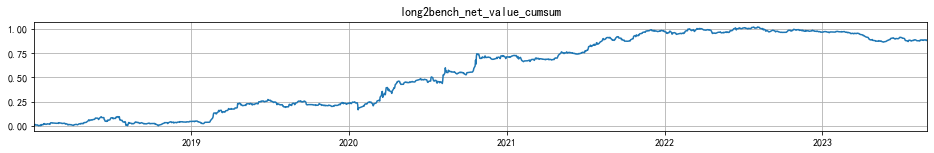

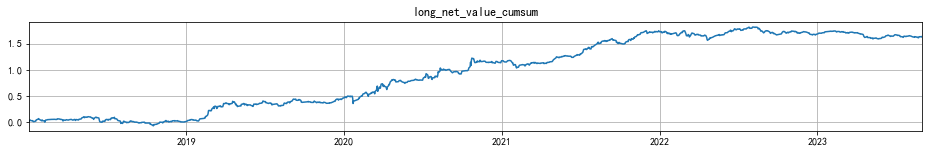

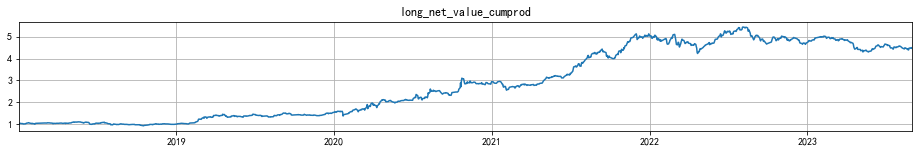

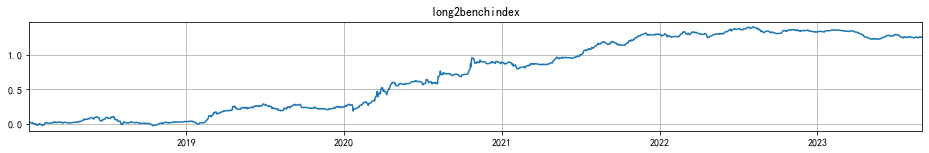

In [203]:
C = SingleFactorAnalysis_CCB(index_pool='ZZZZ',start_date='20180101',end_date='20230901',factor_name='factor_open_60',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=10,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

# 分域后zscore

factor_name: factor_RSI_5
start_date,end_date 2019-01-01 2023-08-14
2019-01-02
2020-01-10
2021-01-21
2022-02-08
2023-02-17


,turnover,gross,net
group_01,0.292084,0.000484,0.000075
group_02,0.425601,0.000333,-0.000263
group_03,0.482224,0.000031,-0.000644
group_04,0.486332,0.000034,-0.000647
group_05,0.481281,0.000007,-0.000667
group_06,0.439217,-0.000064,-0.000679
group_07,0.367122,-0.000183,-0.000697
group_08,0.340519,-0.000232,-0.000709
group_09,0.323964,-0.000148,-0.000602
group_10,0.180427,-0.000262,-0.000514


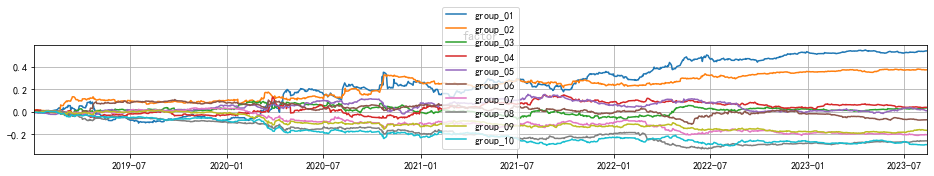

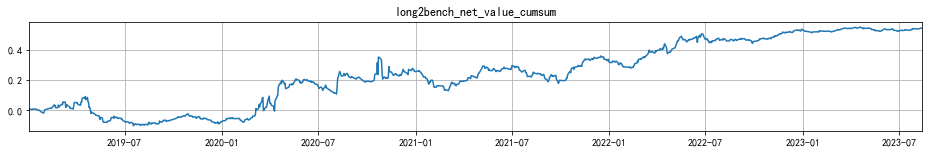

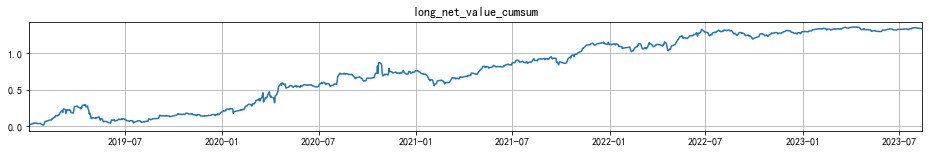

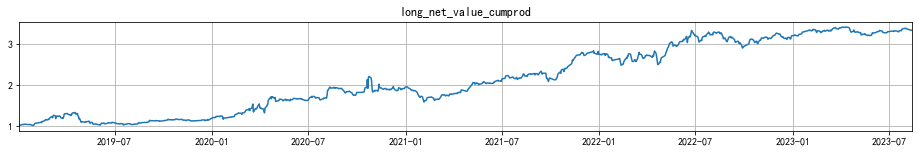

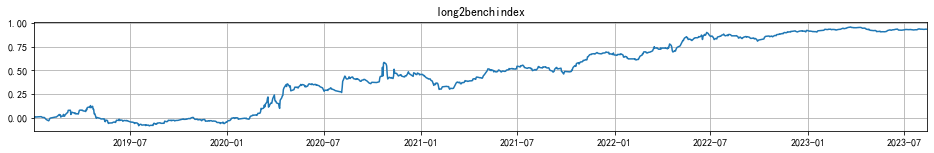

In [226]:
C = SingleFactorAnalysis_CCB(index_pool='ZZZZ',start_date='20190101',end_date='20230814',factor_name='factor_RSI_5',nextpct='pct_close_next_close',long_low=1,dt_index='240m',n_group=10,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_moderate_10
start_date,end_date 2019-01-01 2023-08-14
2019-01-02
2020-01-10
2021-01-21
2022-02-08
2023-02-17


,turnover,gross,net
group_01,0.244204,0.000374,0.000032
group_02,0.485219,0.000383,-0.000296
group_03,0.573028,0.000066,-0.000736
group_04,0.602487,0.000003,-0.000840
group_05,0.605344,-0.000112,-0.000959
group_06,0.603745,-0.000188,-0.001033
group_07,0.597479,-0.000235,-0.001071
group_08,0.572267,-0.000159,-0.000961
group_09,0.501119,0.000159,-0.000543
group_10,0.264822,-0.000291,-0.000662


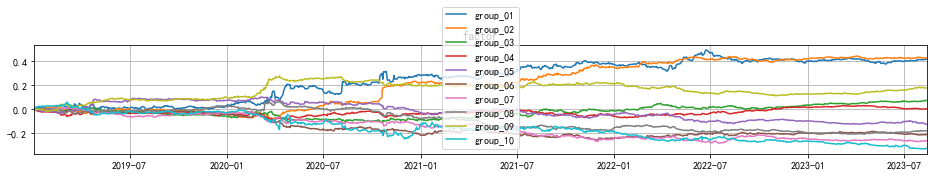

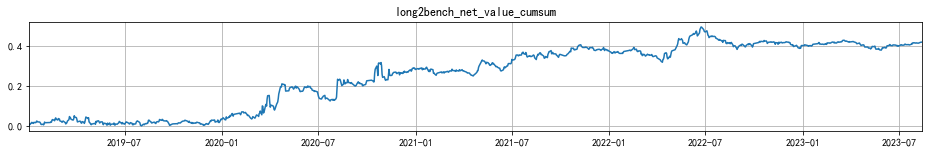

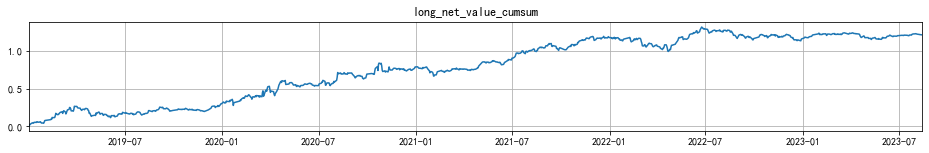

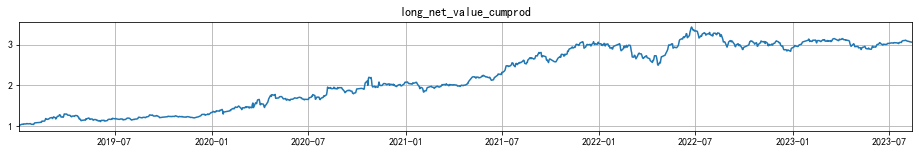

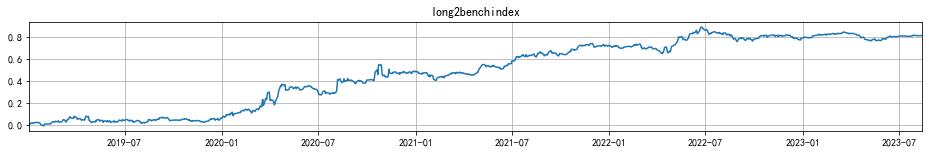

In [227]:
C = SingleFactorAnalysis_CCB(index_pool='ZZZZ',start_date='20190101',end_date='20230814',factor_name='factor_moderate_10',nextpct='pct_close_next_close',long_low=1,dt_index='240m',n_group=10,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_retvar_20
start_date,end_date 2018-01-01 2023-09-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.151512,0.000225,0.000013
group_02,0.258728,0.000194,-0.000168
group_03,0.302719,-0.000028,-0.000452
group_04,0.320583,-0.000156,-0.000605
group_05,0.337148,-0.000117,-0.000589
group_06,0.329208,-0.000155,-0.000616
group_07,0.299009,-0.000097,-0.000516
group_08,0.279882,-0.000009,-0.000401
group_09,0.232932,0.000041,-0.000285
group_10,0.116011,0.000101,-0.000061


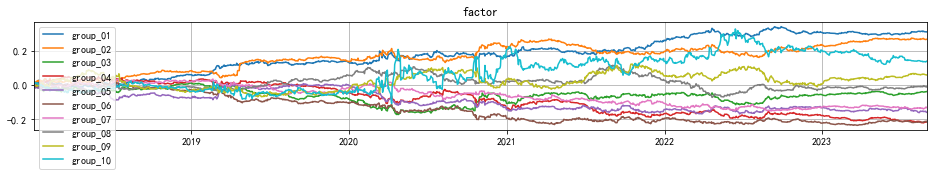

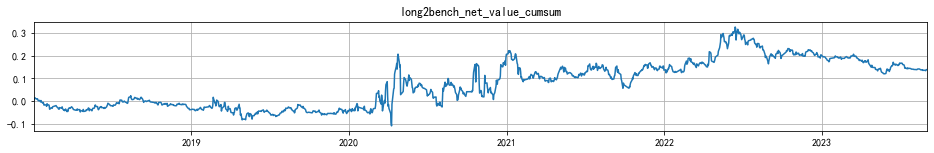

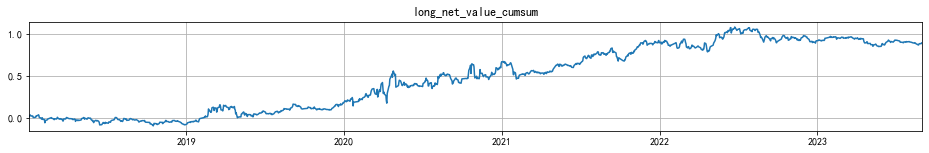

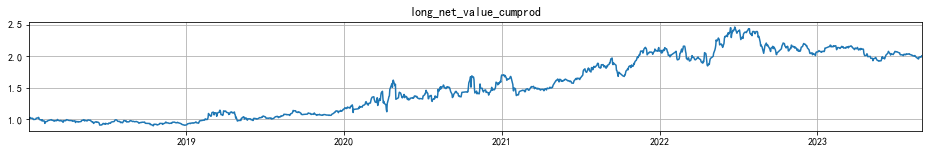

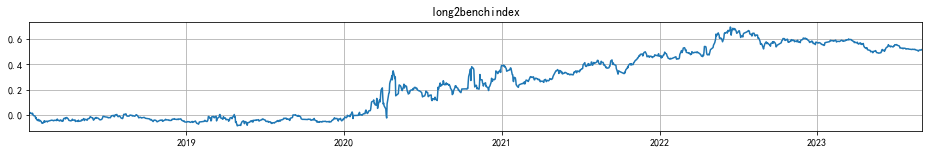

In [228]:
C = SingleFactorAnalysis_CCB(index_pool='ZZZZ',start_date='20180101',end_date='20230901',factor_name='factor_retvar_20',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=10,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_retskew_10_par
start_date,end_date 2019-01-01 2023-08-14
2019-01-02
2020-01-10
2021-01-21
2022-02-08
2023-02-17


,turnover,gross,net
group_01,0.163644,0.000111,-0.000119
group_02,0.310451,0.000040,-0.000395
group_03,0.162892,-0.000151,-0.000379


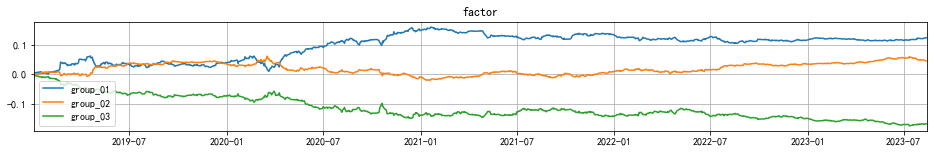

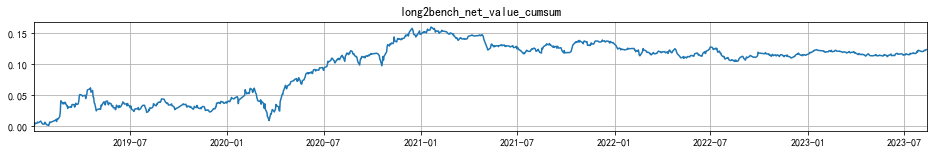

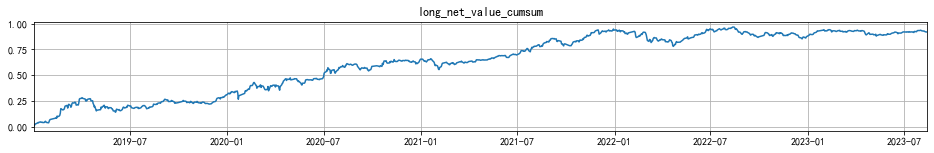

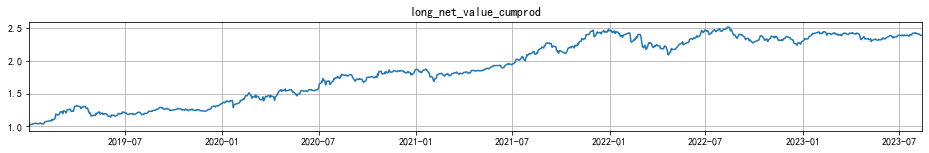

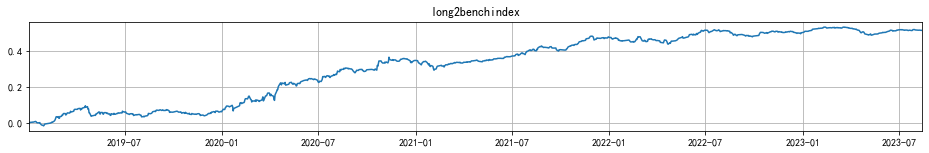

In [229]:
# 平底溢价率中性化后的factor_retskew_10
C = SingleFactorAnalysis_CCB(index_pool='ZZZZ',start_date='20190101',end_date='20230814',factor_name='factor_retskew_10_par',nextpct='pct_close_next_close',long_low=1,dt_index='240m',n_group=3,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_corrstd_10
start_date,end_date 2018-01-01 2023-09-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.172222,-0.000158,-0.000399
group_02,0.299723,0.000066,-0.000353
group_03,0.163478,0.000092,-0.000137


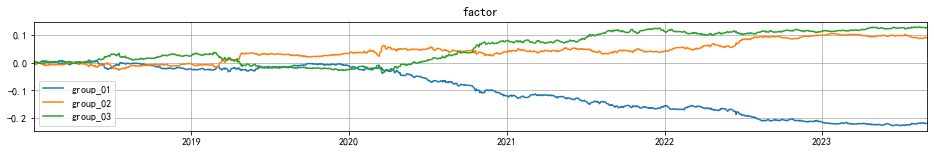

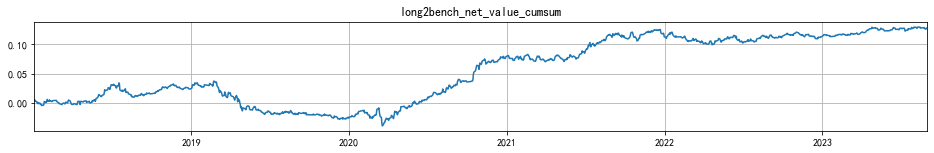

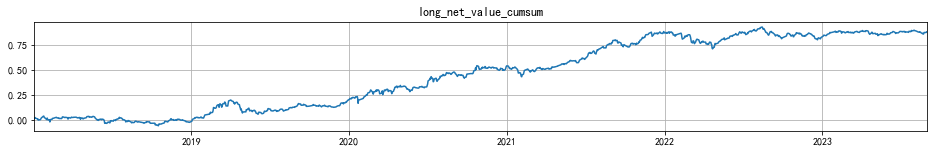

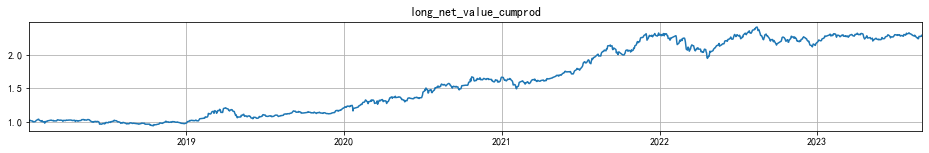

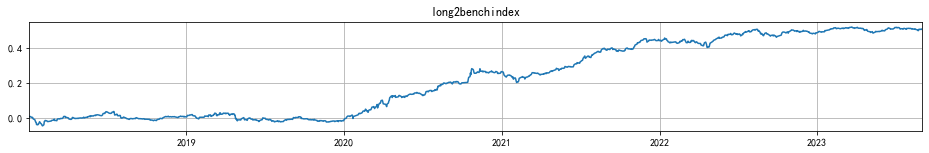

In [230]:
C = SingleFactorAnalysis_CCB(index_pool='ZZZZ',start_date='20180101',end_date='20230901',factor_name='factor_corrstd_10',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=3,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_open_60
start_date,end_date 2018-01-01 2023-09-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.077393,-0.000260,-0.000368
group_02,0.157239,-0.000156,-0.000376
group_03,0.189412,-0.000148,-0.000414
group_04,0.207716,-0.000005,-0.000296
group_05,0.264971,-0.000230,-0.000601
group_06,0.267009,0.000013,-0.000361
group_07,0.217075,-0.000137,-0.000441
group_08,0.206970,0.000130,-0.000160
group_09,0.185771,0.000201,-0.000059
group_10,0.089858,0.000592,0.000466


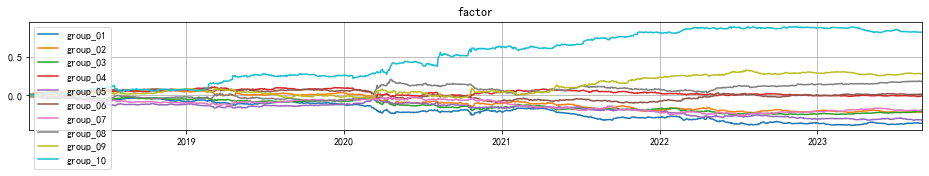

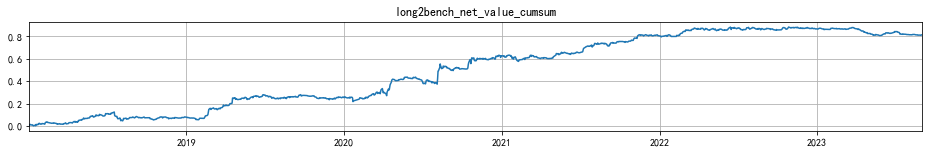

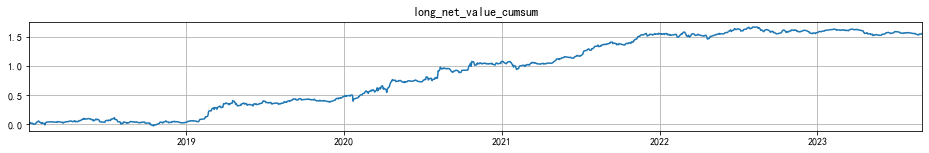

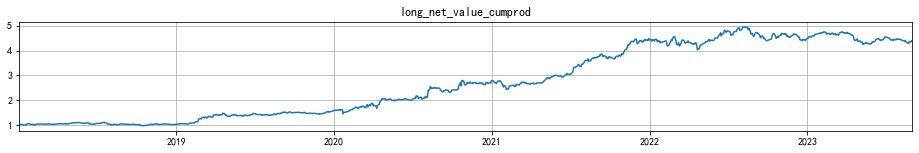

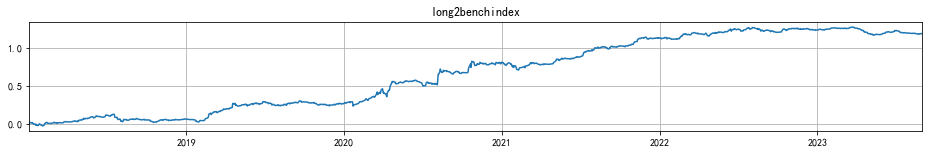

In [231]:
C = SingleFactorAnalysis_CCB(index_pool='ZZZZ',start_date='20180101',end_date='20230901',factor_name='factor_open_60',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=10,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df